In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LinearRegression as LinReg
import sklearn.neighbors as knn
from sklearn.cross_validation import train_test_split
from scipy import linalg
import matplotlib as mpl
%matplotlib inline

# Food Inspection Data

In [3]:
df = pd.read_csv('Food_Inspections.csv')
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Latitude,Longitude,Location
0,1970782,"MARINO'S DISTRIBUTION , INC.",MARINO'S DISTRIBUTION,2495906.0,Grocery Store,Risk 3 (Low),3939 S KEDZIE AVE,CHICAGO,IL,60632.0,11/3/16,License,Pass,41.821458,-87.704350,"(41.82145816352694, -87.70435016027005)"
1,1970772,STARBUCKS COFFEE #2827,STARBUCKS COFFEE #2827,2093906.0,Restaurant,Risk 2 (Medium),1174 E 55TH ST,CHICAGO,IL,60615.0,11/3/16,Canvass,Pass,41.795175,-87.596601,"(41.79517545018063, -87.59660147733702)"
2,1970752,"I 57 FUEL MART, INC","I 57 FUEL MART, INC",2495782.0,Grocery Store,Risk 3 (Low),9901-9909 S HALSTED ST,CHICAGO,IL,60628.0,11/3/16,License,Pass,41.714126,-87.642853,"(41.71412564927746, -87.64285254744291)"
3,1955335,CHIPOTLE MEXICAN GRILL#2768,CHIPOTLE,2476569.0,Restaurant,Risk 1 (High),806 W 63RD ST,CHICAGO,IL,60621.0,11/2/16,License Re-Inspection,Pass,41.779856,-87.645142,"(41.77985559084816, -87.64514243359771)"
4,1955334,CHIPOTLE MEXICAN GRILL#2768,CHIPOTLE,2476568.0,Restaurant,Risk 1 (High),806 W 63RD ST,CHICAGO,IL,60621.0,11/2/16,License Re-Inspection,Pass,41.779856,-87.645142,"(41.77985559084816, -87.64514243359771)"


In [4]:
rest = df[df["Facility Type"] == "Restaurant"]
rest.shape

(87952, 16)

In [5]:
rest.Results.unique()

array(['Pass', 'Pass w/ Conditions', 'Fail', 'No Entry', 'Not Ready',
       'Out of Business', 'Business Not Located'], dtype=object)

In [6]:
rest.Risk.unique()

array(['Risk 2 (Medium)', 'Risk 1 (High)', 'Risk 3 (Low)', 'All', nan], dtype=object)

In [7]:
rest.City.unique()

array(['CHICAGO', nan, 'Chicago', 'CCHICAGO', 'chicago', 'CHICAGOCHICAGO',
       'CHICAGOI'], dtype=object)

## Inspection Type

We've got some data cleanup to do, but we can ignore city since they're all chicago...

In [9]:
rest["Inspection Type"].unique()

array(['Canvass', 'License Re-Inspection', 'Complaint', 'License',
       'Canvass Re-Inspection', 'Short Form Complaint',
       'Complaint Re-Inspection', 'Suspected Food Poisoning Re-inspection',
       'Suspected Food Poisoning', 'Tag Removal', 'Consultation',
       'Recent Inspection', nan, 'Not Ready', 'License-Task Force',
       'Complaint-Fire Re-inspection', 'Complaint-Fire',
       'Short Form Fire-Complaint', 'KITCHEN CLOSED FOR RENOVATION',
       'Non-Inspection', 'CORRECTIVE ACTION', 'LICENSE CANCELED BY OWNER',
       'Task Force Liquor 1475', 'fire complaint',
       'TWO PEOPLE ATE AND GOT SICK.', 'Pre-License Consultation',
       'CANVASS SPECIAL EVENTS', 'OUT OF BUSINESS', 'No entry', 'NO ENTRY',
       'Package Liquor 1474', 'Sample Collection', 'FIRE/COMPLAIN',
       '1315 license reinspection', 'Task Force Liquor Catering', 'SFP',
       'CANVAS', 'no entry', 'SFP/COMPLAINT', 'Special Events (Festivals)',
       'SFP/Complaint', 'expansion', 'SFP RECENTLY INSP

Some of these look suspect... so we'll clean some up.. but what are the task force items? Some of these require some domain specific knowledge to interpret.

In [10]:
#let's cleanup these...
rest.loc[rest["Inspection Type"] == "TWO PEOPLE ATE AND GOT SICK.", "Inspection Type"] = "Suspected Food Poisoning"
rest.loc[rest["Inspection Type"] == "TASK FORCE LIQUOR (1481)","Inspection Type"] = "Task Force Liquor"
rest.loc[rest["Inspection Type"] == "Task Force Liquor 1475","Inspection Type"] = "Task Force Liquor"
rest.loc[rest["Inspection Type"] == "Package Liquor 1474","Inspection Type"] = "Task Force Liquor"
rest.loc[rest["Inspection Type"] == "1315 license reinspection","Inspection Type"] = "License Re-Inspection"
rest.loc[rest["Inspection Type"] == "Out of Business","Inspection Type"] = "OUT OF BUSINESS"
rest.loc[rest["Inspection Type"] == "No entry","Inspection Type"] = "NO ENTRY"
rest.loc[rest["Inspection Type"] == "No Entry","Inspection Type"] = "NO ENTRY"
rest.loc[rest["Inspection Type"] == "LICENSE TASK FORCE / NOT -FOR-PROFIT CLU","Inspection Type"] = "LICENSE TASK FORCE / NOT -FOR-PROFIT CLUB"

/Users/angelo/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
rest["Inspection Type"].unique()

array(['Canvass', 'License Re-Inspection', 'Complaint', 'License',
       'Canvass Re-Inspection', 'Short Form Complaint',
       'Complaint Re-Inspection', 'Suspected Food Poisoning Re-inspection',
       'Suspected Food Poisoning', 'Tag Removal', 'Consultation',
       'Recent Inspection', nan, 'Not Ready', 'License-Task Force',
       'Complaint-Fire Re-inspection', 'Complaint-Fire',
       'Short Form Fire-Complaint', 'KITCHEN CLOSED FOR RENOVATION',
       'Non-Inspection', 'CORRECTIVE ACTION', 'LICENSE CANCELED BY OWNER',
       'Task Force Liquor', 'fire complaint', 'Pre-License Consultation',
       'CANVASS SPECIAL EVENTS', 'OUT OF BUSINESS', 'NO ENTRY',
       'Sample Collection', 'FIRE/COMPLAIN', 'Task Force Liquor Catering',
       'SFP', 'CANVAS', 'no entry', 'SFP/COMPLAINT',
       'Special Events (Festivals)', 'SFP/Complaint', 'expansion',
       'SFP RECENTLY INSPECTED', 'CANVASS',
       'CANVASS RE INSPECTION OF CLOSE UP', 'LICENSE REQUEST', 'TASKFORCE',
       'LICEN

This is interesting! We could combine and cleanup some of these...

In [12]:
#How many difference licenses... but, we need to cleanup some by making some determination...
#some of these businesses have more than one license. Are they separate food & liquor licenses? 
rest["License #"].unique().shape[0]

15854

In [13]:
#We want the business that are pass/fail
rest = rest[(rest["Results"] == "Pass") | (rest["Results"] == "Pass w/ Conditions") | (rest["Results"] == "Fail")]
rest.shape

(78897, 16)

In [14]:
#we'll remove superfluous columns
rest = rest.drop('Location', 1)
rest = rest.drop('State', 1)
rest = rest.drop('City', 1)
rest.shape

(78897, 13)

In [15]:
#let's recode the pass/fail
rest.loc[rest.Results != 'Fail', 'Y'] = 0
rest.loc[rest.Results == 'Fail', 'Y'] = 1

In [16]:
#Here are some interesting pieces of aggregated info based on Inspection Type

insp_types = rest["Inspection Type"].unique()

for i in insp_types:
    insp = rest[rest["Inspection Type"] == i]
    total = float(insp.shape[0])
    if(total != 0):
        print "P(Y=Fail|Inspection Type=%s) = %.4f" % (i, insp[insp["Results"] == 'Fail'].shape[0]/total)
    else:
        print "P(Y=Fail|Inspection Type=%s) = %.4f" % (i, 0)

P(Y=Fail|Inspection Type=Canvass) = 0.1982
P(Y=Fail|Inspection Type=License Re-Inspection) = 0.1080
P(Y=Fail|Inspection Type=Complaint) = 0.3198
P(Y=Fail|Inspection Type=License) = 0.4139
P(Y=Fail|Inspection Type=Canvass Re-Inspection) = 0.0463
P(Y=Fail|Inspection Type=Short Form Complaint) = 0.1273
P(Y=Fail|Inspection Type=Complaint Re-Inspection) = 0.0842
P(Y=Fail|Inspection Type=Suspected Food Poisoning Re-inspection) = 0.0821
P(Y=Fail|Inspection Type=Suspected Food Poisoning) = 0.2482
P(Y=Fail|Inspection Type=Tag Removal) = 0.0435
P(Y=Fail|Inspection Type=Consultation) = 0.1448
P(Y=Fail|Inspection Type=Recent Inspection) = 0.0690
P(Y=Fail|Inspection Type=nan) = 0.0000
P(Y=Fail|Inspection Type=Complaint-Fire Re-inspection) = 0.1053
P(Y=Fail|Inspection Type=Complaint-Fire) = 0.3902
P(Y=Fail|Inspection Type=Short Form Fire-Complaint) = 0.2738
P(Y=Fail|Inspection Type=Non-Inspection) = 1.0000
P(Y=Fail|Inspection Type=License-Task Force) = 0.5986
P(Y=Fail|Inspection Type=CORRECTIVE ACTI

Some of these zeros and ones can be removed... 

In [17]:
#What's the proportion of business that fail a license request?
lic = rest[rest["Inspection Type"] == 'LICENSE REQUEST']
lic[lic["Results"] == 'Fail'].shape[0]/float(lic.shape[0])

1.0

So, it looks like everyone fails when they first apply for a license... that's probably not relevent to us, so we could discard those

In [18]:
lic.Results.unique()

array(['Fail'], dtype=object)

In [19]:
#ok, so every fails a lincense request the first time... (I wonder if that means we can exclude those)
#what about a license reinspection?
lic = rest[rest["Inspection Type"] == 'License Re-Inspection']
lic[lic["Results"] == 'Fail'].shape[0]/float(lic.shape[0])

0.10801493823613904

## Number of Inspections

When reinspected, 90% pass. I wonder if the 10% that fail here will fail over and over again? Worth considering

In [20]:
#How many inspections per license
df_inspection_counts = pd.DataFrame()
res = rest[["Results", "License #"]].groupby("License #").count()

df_inspection_counts["total_inspections"] = res["Results"].reset_index()["Results"]

failures = rest[rest["Results"] == "Fail"]
res = failures[["Results", "License #"]].groupby("License #").count()

df_inspection_counts["failed_inspections"] = res["Results"].reset_index()["Results"]

df_inspection_counts = df_inspection_counts.fillna(0, axis=0)

df_inspection_counts["prop"] = df_inspection_counts["failed_inspections"]/df_inspection_counts["total_inspections"]

In [21]:
df_inspection_counts["total_inspections"].mean()

5.2011998154130135

On average, there are 5 inspections per license.

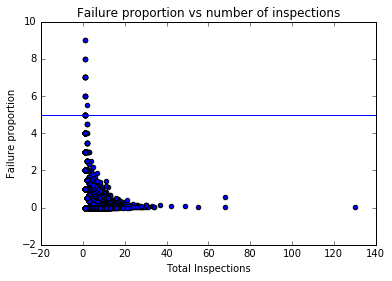

In [22]:
#df_inspection_counts
plt.scatter(df_inspection_counts["total_inspections"], df_inspection_counts["prop"] )
plt.axhline(5, label="Mean")
plt.xlabel("Total Inspections")
plt.ylabel("Failure proportion")
plt.title("Failure proportion vs number of inspections")

This is interesting... The more times an establishment is inspected, the smaller the failure proportion. That could mean a lot of things... does it mean they get better over time? You'd think that the more complaints, the more inspections, and the more failures...

In [23]:
rest[["Results", "License #"]].groupby("License #").count().head(5)

,Results
License #,
0.0,68
2.0,10
9.0,9
40.0,12
62.0,11


## Inspection Frequency

In [24]:
for a in rest["Inspection Date"].unique():
    if len(a) != 10:
        print a

11/3/16
11/2/16
11/1/16
10/18/16
10/28/16
10/31/16
10/27/16
10/26/16
10/25/16
10/24/16
10/21/16
10/20/16
10/17/16
10/14/16
10/19/16
9/20/16
10/13/16
10/11/16
10/12/16
10/7/16
10/4/16
10/6/16
9/30/16
9/13/16
9/16/16
10/5/16
9/23/16
10/3/16
9/29/16
9/28/16
9/27/16
9/26/16
9/22/16
8/8/16
7/25/16
7/13/16
8/30/16
9/21/16
7/29/16
12/29/15
7/5/16
9/19/16
9/15/16
8/2/16
9/14/16
9/9/16
9/1/16
9/8/16
6/23/16
9/12/16
6/15/16
6/13/16
9/7/16
4/7/16
8/31/16
9/6/16
9/2/16
8/29/16
3/3/16
8/23/16
2/25/16
8/22/16
8/18/16
8/5/16
8/12/16
8/26/16
6/2/16
5/12/16
8/24/16
10/23/15
11/24/15
8/10/16
8/19/16
11/9/15
8/11/16
3/8/16
4/28/16
8/17/16
8/16/16
8/15/16
8/4/16
9/2/15
7/28/16
10/1/15
1/26/16
8/9/16
1/14/16
7/27/16
8/3/16
9/23/15
12/3/15
8/1/16
7/16/15
7/26/16
7/13/15
7/15/15
6/25/15
7/19/16
7/8/16
5/4/16
7/22/16
7/15/16
7/21/16
7/7/16
12/24/15
7/20/16
6/30/16
10/6/15
7/18/16
6/21/16
7/14/16
2/19/16
2/18/16
9/22/15
6/17/16
7/12/16
5/28/15
5/11/15
7/11/16
5/20/16
7/6/16
5/25/16
4/23/15
4/28/15
4/24/15
7/1/

In [25]:
#avg # inspections per year
rest["inspection_dt"] = pd.to_datetime(rest["Inspection Date"])
rest.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Latitude,Longitude,Y,inspection_dt
1,1970772,STARBUCKS COFFEE #2827,STARBUCKS COFFEE #2827,2093906.0,Restaurant,Risk 2 (Medium),1174 E 55TH ST,60615.0,11/3/16,Canvass,Pass,41.795175,-87.596601,0.0,2016-11-03
3,1955335,CHIPOTLE MEXICAN GRILL#2768,CHIPOTLE,2476569.0,Restaurant,Risk 1 (High),806 W 63RD ST,60621.0,11/2/16,License Re-Inspection,Pass,41.779856,-87.645142,0.0,2016-11-02
4,1955334,CHIPOTLE MEXICAN GRILL#2768,CHIPOTLE,2476568.0,Restaurant,Risk 1 (High),806 W 63RD ST,60621.0,11/2/16,License Re-Inspection,Pass,41.779856,-87.645142,0.0,2016-11-02
5,1970747,SUBWAY #4267,SUBWAY,2354431.0,Restaurant,Risk 1 (High),115 E 51ST ST,60615.0,11/2/16,Canvass,Pass w/ Conditions,41.801902,-87.621926,0.0,2016-11-02
6,1970728,SANTULLO'S EATERY,SANTULLO'S EATERY,1767714.0,Restaurant,Risk 1 (High),1943-1945 W NORTH AVE,60622.0,11/2/16,Complaint,Fail,41.910387,-87.676831,1.0,2016-11-02


In [243]:
dt_grp = rest[["Results", "License #"]].groupby(["License #", rest["inspection_dt"].dt.year]).count()
dt_grp.head()

Results
License # inspection_dt         
0.0       2010                 5
          2011                 8
          2012                20
          2013                 8
          2014                 9

In [203]:
temp = dt_grp["Results"].reset_index()
temp[temp.inspection_dt == 2016]["Results"].mean()

1.4967281380130875

## Repeat Offenders

The average number inspections per license. This might be interesting to consider how a particular establishment compares to the mean, and their failure rate.

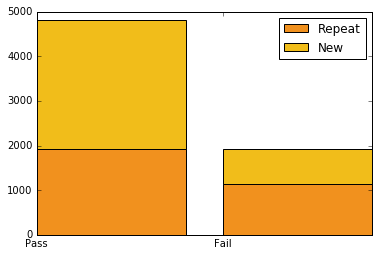

In [230]:
#previous failure have any bearing on next? show prop of failures with a previous one
#let's take only 2016 and see if any failure in the past
#we'll recode 2016 and past.. and see if there's any correlation between them
#let's calculate P(Y=1|Y_past=1) vs P(Y=1)
previous_fails = pd.DataFrame()
this_year = rest[rest["inspection_dt"].dt.year == 2016]
previous_years = rest[rest["inspection_dt"].dt.year < 2016]
temp = this_year[["License #", "Y"]].groupby("License #").max()

previous_fails = temp
previous_fails = previous_fails.reset_index("License #")

temp = previous_years[["License #", "Y"]].groupby("License #").max()
previous_fails["previous_F"] = temp.reset_index()["Y"]

#let's do some calculations and plotting:

#plt.hist(previous_fails[previous_fails["Y"] == previous_fails["previous_F"]]["Y"])
repeat_fail = previous_fails[(previous_fails["Y"] == 1) & (previous_fails["previous_F"] == 1)]["Y"].count()
new_fail = previous_fails[(previous_fails["Y"] == 1) & (previous_fails["previous_F"] == 0)]["Y"].count()
repeat_pass = previous_fails[(previous_fails["Y"] == 0) & (previous_fails["previous_F"] == 0)]["Y"].count()
new_pass = previous_fails[(previous_fails["Y"] == 0) & (previous_fails["previous_F"] == 1)]["Y"].count()
repeats = [repeat_fail, repeat_pass]
plt.bar([1,0],[repeat_fail, repeat_pass], label="Repeat", color='#F1911E')
plt.bar([1,0], [new_fail, new_pass], bottom=[repeat_fail, repeat_pass], label="New", color='#F1BD1A')
plt.xticks([1,0], ("Fail", "Pass"))

plt.legend(loc="best")

This is a bar plot of the repeat vs new pass/fail. The dark color is the repeat passers (good businesses) and failures (repeat offenders). the lighter color are first time passers and first time offenders.

In [231]:
#risk?
failures_by_risk = rest[["Results", "Risk"]].groupby("Risk").count()
failures_by_risk[failures_by_risk["Risk"]]

,Results
Risk,
All,1
Risk 1 (High),62508
Risk 2 (Medium),15577
Risk 3 (Low),808


In [232]:
#overall probability of failing:
rest[rest["Y"] == 1].shape[0]/float(rest.shape[0])

0.20896865533543735

## Risk Score

In [241]:
#how do the risk categories compare?
failures = rest[rest["Y"] == 1]

print "P(Risk=1|Y=1) = %4f" % (failures[failures["Risk"] == "Risk 1 (High)"].shape[0]/float(failures.shape[0]))
print "P(Risk=1) = %4f" % (rest[rest["Risk"] == "Risk 1 (High)"].shape[0]/float(rest.shape[0]))
print "# of Risk 1 passing = %4f" % (rest[(rest["Risk"] == "Risk 1 (High)") & (rest["Y"] == 0)].shape[0])

print "P(Risk=2|Y=1) = %4f" % (failures[failures["Risk"] == "Risk 2 (Medium)"].shape[0]/float(failures.shape[0]))
print "P(Risk=2) = %4f" % (rest[rest["Risk"] == "Risk 2 (Medium)"].shape[0]/float(rest.shape[0]))
print "# of Risk 2 passing = %4f" % (rest[(rest["Risk"] == "Risk 2 (Medium)") & (rest["Y"] == 0)].shape[0])

print "P(Risk=3|Y=1) = %4f" % (failures[failures["Risk"] == "Risk 3 (Low)"].shape[0]/float(failures.shape[0]))
print "P(Risk=3) = %4f" % (rest[rest["Risk"] == "Risk 3 (Low)"].shape[0]/float(rest.shape[0]))
print "# of Risk 4 passing = %4f" % (rest[(rest["Risk"] == "Risk 3 (Low)") & (rest["Y"] == 0)].shape[0])

P(Risk=1|Y=1) = 0.799418
P(Risk=1) = 0.792273
# of Risk 1 passing = 49328.000000
P(Risk=2|Y=1) = 0.187117
P(Risk=2) = 0.197435
# of Risk 2 passing = 12492.000000
P(Risk=3|Y=1) = 0.013223
P(Risk=3) = 0.010241
# of Risk 4 passing = 590.000000


Risk is interesting. Are they assessed this after inspection, or by the license type before hand? In any case, Failure seems to strongly follow risk for whatever reason.

## Failures by month

In [36]:
failures = rest[rest["Y"] == 1]
month_fail_grp = failures[["Results"]].groupby(failures["inspection_dt"].dt.month).count()
month_fail_grp = month_fail_grp.reset_index()

month_all_grp = rest[["Results"]].groupby(rest["inspection_dt"].dt.month).count()
month_all_grp = month_all_grp.reset_index()

df_by_month = pd.DataFrame()
df_by_month["failures"] = month_fail_grp["Results"]
df_by_month["total"] = month_all_grp["Results"]
df_by_month["fail_prop"] = df_by_month["failures"]/df_by_month["total"]

df_by_month

,failures,total,fail_prop
0,1233,6288,0.196088
1,1246,6078,0.205002
2,1397,7201,0.194001
3,1417,6903,0.205273
4,1496,7216,0.207317
5,1594,7432,0.214478
6,1449,6494,0.223129
7,1669,7487,0.222920
8,1651,7132,0.231492
9,1417,6806,0.208199


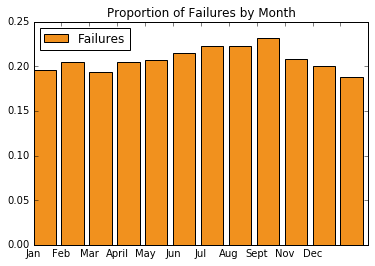

In [39]:
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11],df_by_month["fail_prop"], label="Failures", color='#F1911E')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], ("Jan", "Feb", "Mar", "April", "May", "Jun", "Jul", "Aug", "Sept", "Nov", "Dec"))
plt.legend(loc="best")
plt.title("Proportion of Failures by Month")

In [42]:
failures = rest[rest["Y"] == 1]
day_fail_grp = failures[["Results"]].groupby(failures["inspection_dt"].dt.weekday).count()
day_fail_grp = day_fail_grp.reset_index()

day_all_grp = rest[["Results"]].groupby(rest["inspection_dt"].dt.weekday).count()
day_all_grp = day_all_grp.reset_index()

df_by_day = pd.DataFrame()
df_by_day["failures"] = day_fail_grp["Results"]
df_by_day["total"] = day_all_grp["Results"]
df_by_day["fail_prop"] = df_by_day["failures"]/df_by_day["total"]

df_by_day

,failures,total,fail_prop
0,2872,13243,0.216869
1,3907,17821,0.219236
2,2832,14333,0.197586
3,3849,18205,0.211425
4,3019,15265,0.197773
5,8,26,0.307692


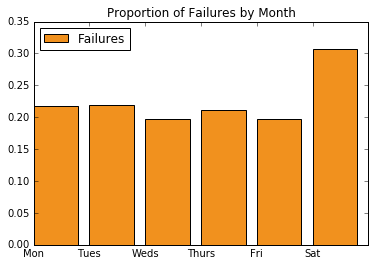

In [44]:
plt.bar([0,1,2,3,4,5],df_by_day["fail_prop"], label="Failures", color='#F1911E')
plt.xticks([0,1,2,3,4,5], ("Mon", "Tues", "Weds", "Thurs", "Fri", "Sat"))
plt.legend(loc="best")
plt.title("Proportion of Failures by Month")